In [1]:
import copy
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect
import pandas as pd

sys.path.insert(0, "..")
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
Q1_THEORY_DIR = "../dump/q1_theory/"
Q1_BOXATK_DIR = "../dump/q1_boxatk/"
Q2_DIR = "../dump/q2"
Q3_DIR = "../dump/q3_sparsity"

In [3]:
#######################################################
# Q1 ##################################################
#######################################################

In [4]:
def load_q1_theory(model_type, method_type, top_frac, lambd):
    model_type = model_type.lower()
    method_type = method_type.lower()
    method_type = "vgradu" if method_type == "vgrad" else method_type
    method_type = "igradu" if method_type == "igrad" else method_type
    
    if model_type == "roberta":
        csv_file = f"q1t_{model_type}_q64_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q1t_{model_type}_psz28_q64_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q1_THEORY_DIR, csv_file)
    return pd.read_csv(csv_file)

def load_q1_boxatk(model_type, method_type, top_frac, lambd):
    if model_type == "roberta":
        csv_file = f"q1e_{model_type}_q16_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q1e_{model_type}_psz28_q16_{method_type}_top{top_frac:.4f}_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q1_BOXATK_DIR, csv_file)
    return pd.read_csv(csv_file)

# Certified stuff
def q1t_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    ones_gaps = (df["ones_mu_gap"] if use_mu else df["ones_gap"]).to_numpy()
    exbs_gaps = (df["exbs_mu_gap"] if use_mu else df["exbs_gap"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    todo_gaps = exbs_gaps if prop == "inc" else ones_gaps
    
    N = len(df)
    lambd = df["lambd"][0]
    cert_rs = todo_gaps / (2 * lambd)
    
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    
    if consistent:
        hit_bits = ones_labels == exbs_labels
#         hit_bits = true_labels == exbs_labels
#         hit_bits = true_labels == true_labels
#         hit_bits = true_labels == todo_labels
#         print(f"num hits {hit_bits.sum()}")
        drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(cert_rs >= r).sum() / N for r in rs])

    return drops

# Box attack stuff
def q1e_drops(df, rs, prop="inc", consistent=True, div_by_p=False, use_mu=False):
    assert prop in ["inc", "dec"]
    
    true_labels = df["true_label"].to_numpy()
    ones_labels = (df["ones_mu_label"] if use_mu else df["ones_label"]).to_numpy()
    exbs_labels = (df["exbs_mu_label"] if use_mu else df["exbs_label"]).to_numpy()
    todo_labels = exbs_labels if prop == "inc" else ones_labels
    r_maxs = (df["inc_curr_r_max"] if prop == "inc" else df["dec_curr_r_max"]).to_numpy()
        
    N = len(df)
    r_maxs = r_maxs / df["p"].to_numpy() if div_by_p else r_maxs
    if consistent:
        hit_bits = ones_labels == exbs_labels
        drops = np.array([hit_bits[r_maxs >= r].sum() / N for r in rs])
    else:
        drops = np.array([(r_maxs >= r).sum() / N for r in rs])
    return drops


In [5]:
#######################################################
# Certified accuracy drop plots
#######################################################

In [6]:
def load_q2(model_type, lambd):
    if model_type == "roberta":
        csv_file = f"q2_{model_type}_q64_lam{lambd:.4f}.csv"
    else:
        csv_file = f"q2_{model_type}_psz28_q64_lam{lambd:.4f}.csv"
    csv_file = os.path.join(Q2_DIR, csv_file)
    return pd.read_csv(csv_file)

def q2_drops(df, rs, div_by_p=False):
    true_labels = df["true_label"].to_numpy()
    ones_labels = df["ones_label"].to_numpy()
    N = len(df)
    hit_bits = true_labels == ones_labels
    cert_rs = df["cert_r"].to_numpy()
    if div_by_p:
        ps = df["p"].to_numpy()
        cert_rs = cert_rs / ps
    drops = np.array([hit_bits[cert_rs >= r].sum() / N for r in rs])
    return drops


In [7]:
q2_rs = np.linspace(0.0, 10.01, 802)
q2_rs_roberta = np.linspace(0.0, 0.501, 502)

In [8]:
########################################################

In [9]:
def plot_blog(model_type, trs, plot_trs,
                        title = None,
                        lfs = 12,
                        afs = 14,
                        tfs = 16):
    plt.clf()
    fig, ax = plt.subplots(1,2, figsize=(6.4 * 1.8, 4.8*0.7))

    lambds = [8/8, 4/8, 2/8, 1/8]
    q1t_dfs = [(l, load_q1_theory(model_type, "shap", 0.25, l)) for l in lambds]
    q2_dfs = [(l,load_q2(model_type, l)) for l in lambds]
    div_by_p = model_type.lower() == "roberta"
    
    for (lambd, df) in q1t_dfs:
        inc_drops = q1t_drops(df, trs, prop="inc", div_by_p=div_by_p)
        ax[0].plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
            
    for (lambd, df) in q2_dfs:
        acc_drops = q2_drops(df, trs)
        ax[1].plot(plot_trs, acc_drops, label=f"λ={int(lambd*8)}/8 ({acc_drops[0]:.3f})")

#     fig.subplots_adjust(hspace=0.35)
        
    for i in range(2):
        ax[i].legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
        ax[i].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8])
        ax[i].tick_params(axis="x", labelsize=lfs)
        ax[i].tick_params(axis="y", labelsize=lfs)

    ax[0].set_xlabel("Fraction of Features", fontsize=afs)
    ax[1].set_xlabel("Fraction of Features", fontsize=afs)
    
    ax[0].set_ylabel("Property Hold Rate", fontsize=afs)
    ax[1].set_ylabel("Certified Accuracy", fontsize=afs)
    
    ax[0].set_title("Consistent and Incrementally Stable", fontsize=tfs)
    ax[1].set_title("Certified Accuracy", fontsize=tfs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.93)
    
    return fig

<Figure size 640x480 with 0 Axes>

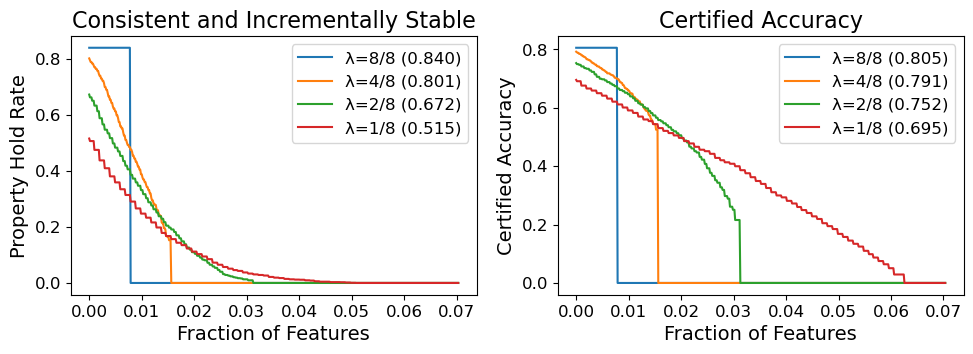

In [10]:
q1t_vit16_rs = np.linspace(0.0, 4.5, 500)
q1t_vit16_plot_rs = q1t_vit16_rs / 64
q1e_vit16_rs = np.linspace(0.0, 31.9, 500)
q1e_vit16_plot_rs = q1e_vit16_rs / 64
_ = plot_blog("vit16", q1t_vit16_rs, q1t_vit16_plot_rs, title=None)
plt.savefig("images/blog_plots.png", bbox_inches="tight", transparent=True)

In [11]:
def plot_inc_stable(model_type, trs, plot_trs,
                        consistent = True,
                        title = None,
                        lfs = 12,
                        afs = 14,
                        tfs = 16):
    plt.clf()
    
    lambds = [8/8, 4/8, 2/8, 1/8]
    q1t_dfs = [(l, load_q1_theory(model_type, "shap", 0.25, l)) for l in lambds]
    div_by_p = model_type.lower() == "roberta"
    
    for (lambd, df) in q1t_dfs:
        inc_drops = q1t_drops(df, trs, prop="inc", div_by_p=div_by_p, consistent=consistent)
        plt.plot(plot_trs, inc_drops, label=f"λ={int(lambd*8)}/8 ({inc_drops[0]:.3f})")
        
    plt.legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    plt.tick_params(axis="x", labelsize=lfs)
    plt.tick_params(axis="y", labelsize=lfs)

    plt.xlabel("Fraction of Features", fontsize=afs)
    plt.ylabel("Fraction of Sample with Property", fontsize=afs)    
    plt.title(title, fontsize=tfs)

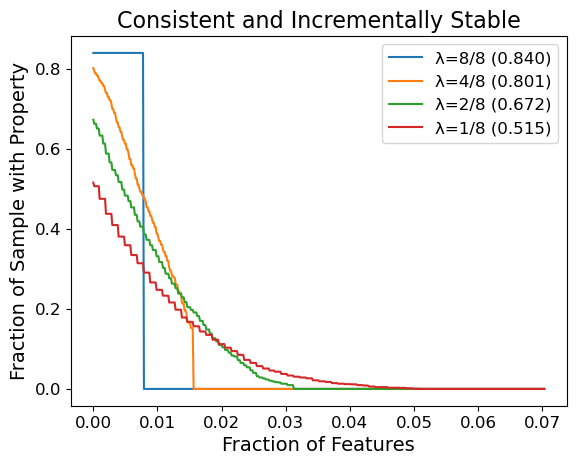

In [12]:
_ = plot_inc_stable("vit16", q1t_vit16_rs, q1t_vit16_plot_rs,
                    consistent = True,
                    title="Consistent and Incrementally Stable")
plt.savefig("images/blog_cons_inc_stable.png", bbox_inches="tight", transparent=True)

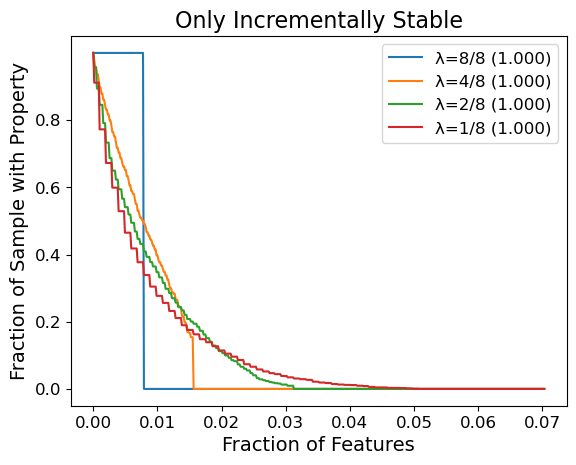

In [13]:

_ = plot_inc_stable("vit16", q1t_vit16_rs, q1t_vit16_plot_rs,
                    consistent = False,
                    title="Only Incrementally Stable")
plt.savefig("images/blog_inc_stable.png", bbox_inches="tight", transparent=True)

In [14]:
def plot_cert_acc(model_type, trs, plot_trs,
                        title = None,
                        lfs = 12,
                        afs = 14,
                        tfs = 16):
    plt.clf()

    lambds = [8/8, 4/8, 2/8, 1/8]
    q2_dfs = [(l,load_q2(model_type, l)) for l in lambds]
    div_by_p = model_type.lower() == "roberta"
            
    for (lambd, df) in q2_dfs:
        acc_drops = q2_drops(df, trs)
        plt.plot(plot_trs, acc_drops, label=f"λ={int(lambd*8)}/8 ({acc_drops[0]:.3f})")
        
    plt.legend(loc="upper right", fontsize=lfs, title_fontsize=lfs)
    plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8])
    plt.tick_params(axis="x", labelsize=lfs)
    plt.tick_params(axis="y", labelsize=lfs)

    plt.xlabel("Fraction of Features", fontsize=afs)
    plt.ylabel("Certified Accuracy", fontsize=afs)
    plt.title("Certified Accuracy", fontsize=tfs)
    
    if title is not None:
        fig.suptitle(title, fontsize=tfs, y=0.93)
    

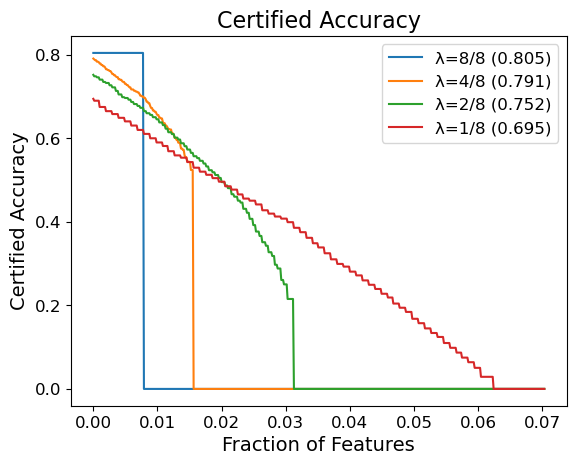

In [15]:
_ = plot_cert_acc("vit16", np.linspace(0.0, 4.51, 500), q1t_vit16_plot_rs, title=None)
plt.savefig("images/blog_cert_acc.png", bbox_inches="tight", transparent=True)